# Audio Embedders

In [8]:
#| default_exp audio.embedding

In [9]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EncoDec

In [60]:
#| export
from encodec import EncodecModel
from encodec.utils import convert_audio

import torchaudio
import torch

from lhotse.features import FeatureExtractor
from lhotse.utils import compute_num_frames, Seconds
from lhotse import CutSet

from matplotlib import pyplot as plt
import IPython.display as ipd
import numpy as np

from dataclasses import asdict, dataclass
from typing import Any, Dict, List, Optional, Pattern, Union
from plum import dispatch

from nimrod.audio.utils import plot_waveform

In [110]:
#| export
class EncoDec():
    def __init__(self, device:str='cpu'):
        self.model = EncodecModel.encodec_model_24khz()
        self._device = device
        self.model.to(self._device)
        self.model.set_target_bandwidth(6.0)

    @dispatch
    def __call__(self, wav:torch.Tensor, sr:int)->torch.Tensor:
        # (CxT) -> (CxDxT_frames)
        if sr != self.model.sample_rate:
            wav = convert_audio(wav, sr, self.model.sample_rate, self.model.channels) # model.sample_rate=24kHz
        wav = wav.unsqueeze(0)
        with torch.no_grad():
            encoded_frames = self.model.encode(wav)
        codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)
        return(codes)
    
    @dispatch
    def __call__(self, wav:np.ndarray, sr:int)->torch.Tensor:
        wav = torch.from_numpy(wav).float()
        if sr != self.model.sample_rate:
            wav = convert_audio(wav, sr, self.model.sample_rate, self.model.channels) # model.sample_rate=24kHz
        wav = wav.unsqueeze(0)
        with torch.no_grad():
            encoded_frames = self.model.encode(wav.to(self._device))
        codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)
        return(codes)

    def decode(self, codes:torch.Tensor)->torch.Tensor:
        # (CxDxT_frames) -> (CxT)
        frames_from_code = [(codes, None)]
        return(self.model.decode(encoded_frames=frames_from_code))

    @property
    def sample_rate(self):
        return self.model.sample_rate
    
    @property
    def device(self):
        return self._device

### Usage

wav: torch.Size([1, 102400]), code: torch.Size([1, 8, 480]) 


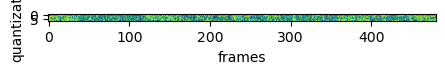

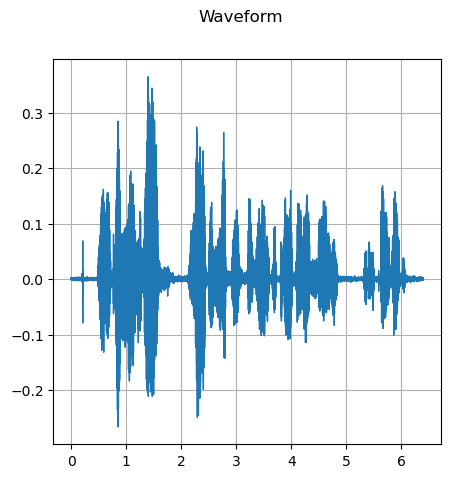

In [114]:
wav, sr = torchaudio.load("../data/obama.wav")
# wav, sr = torch.rand((1, 24000)), 24000
# wav, sr = np.random.random((1, 24000)), 24000

encodec = EncoDec(device='cpu')
codes = encodec(wav,sr)
print(f"wav: {wav.shape}, code: {codes.shape} ")
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel('frames')
plt.ylabel('quantization')
plt.imshow(codes.squeeze().cpu().numpy())
decoded = encodec.decode(codes)
plot_waveform(decoded.detach().cpu().squeeze(0), encodec.sample_rate)


In [14]:
#| hide
ipd.Audio(wav.squeeze(0).numpy(), rate=sr)

### Lhotse Feature extractor

In [118]:
#| export

@dataclass
class EncoDecConfig:
    # The encoder produces embeddings at 75 Hz for input waveforms at 24 kHz,
    # which is a 320-fold reduction in the sampling rate.
    frame_shift: float = 320.0 / 24000
    n_qs: int = 8

class EncoDecExtractor(FeatureExtractor):
    def __init__(self, config=EncoDecConfig()):
        super().__init__(config)
        self.encodec = EncoDec()

    def extract(self, samples:Union[torch.Tensor, np.ndarray], sampling_rate: int) -> np.ndarray:    
        codes = self.encodec(samples, sampling_rate)
        duration = round(samples.shape[-1] / sampling_rate, ndigits=12)
        expected_num_frames = compute_num_frames(
            duration=duration,
            frame_shift=self.frame_shift,
            sampling_rate=sampling_rate,
        )
        assert abs(codes.shape[-1] - expected_num_frames) <= 1
        codes = codes[..., :expected_num_frames]
        return codes.cpu().squeeze(0).permute(1, 0).numpy()

    @property
    def frame_shift(self)->float:
        return self.config.frame_shift

    def feature_dim(self, sampling_rate: int) -> int:
        return self.config.n_q

    

In [119]:
encodec_extractor = EncoDecExtractor()
cuts = CutSet.from_file("../data/en/LJSpeech-1.1/first_3.jsonl.gz")
print(cuts[0])


MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=None, recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)


In [33]:
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

In [122]:
# TODO: make it work with num_jobs>1
cuts = cuts.compute_and_store_features(
    extractor=encodec_extractor,
    storage_path="../data/en/LJSpeech-1.1/encodec",
    num_jobs=1,
)
cuts.to_file("../data/en/LJSpeech-1.1/cuts_encodec.jsonl.gz")

Extracting and storing features:   0%|          | 0/3 [00:00<?, ?it/s]

## AudioLM

In [ ]:
# TO DO

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()